In [12]:
import json
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.models import resnet50
from torchvision import models
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import torch.nn as nn
import torch.optim as optim


In [13]:
torch.cuda.empty_cache()

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', do_lower_case=True)

class HatefulMemeDataset(Dataset):
    def __init__(self, json_file, tokenizer=None):
        self.tokenizer = tokenizer
        if tokenizer is None:
            self.tokenizer = BertTokenizer.from_pretrained(
                'bert-base-uncased', do_lower_case=True)

        with open(json_file, "r") as f:
            self.data = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # img_path = os.path.join(self.img_dir, self.data[index]["img"])
        # image = Image.open(img_path).convert("RGB")

        # if self.transform is not None:
        #     image = self.transform(image)
        text = self.data[index]["text"]
        inputs = self.tokenizer.encode_plus(
            text,                      # Input sentence
            
            max_length=140,                # Pad or truncate all sentences
            return_tensors='pt',           # Return PyTorch tensors
            padding='max_length',
            truncation=True,
        )

        label = self.data[index]["label"]

        return inputs['input_ids'][0], inputs['attention_mask'][0], label


In [15]:
# Load the datasets
train_dataset = HatefulMemeDataset(
    json_file="data/train.jsonl",  tokenizer=tokenizer)
val_dataset = HatefulMemeDataset(
    json_file="data/dev_seen.jsonl",  tokenizer=tokenizer)
valu_dataset = HatefulMemeDataset(
    json_file="data/dev_unseen.jsonl",  tokenizer=tokenizer)
testA_dataset = HatefulMemeDataset(
    json_file="data/test_seen.jsonl", tokenizer=tokenizer)
testB_dataset = HatefulMemeDataset(
    json_file="data/test_unseen.jsonl", tokenizer=tokenizer)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=4)
valu_loader = DataLoader(valu_dataset, batch_size=32,
                        shuffle=False, num_workers=4)
testA_loader = DataLoader(testA_dataset, batch_size=32,
                         shuffle=False, num_workers=4)
testB_loader = DataLoader(testB_dataset, batch_size=32,
                          shuffle=False, num_workers=4)


In [16]:
for inputs, masks, labels in train_loader:
    print(inputs.shape)
    print(masks.shape)
    print(labels.shape)
    break

torch.Size([32, 140])
torch.Size([32, 140])
torch.Size([32])


In [20]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=2)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_batch_size = 32
val_batch_size = 32
num_epochs = 10

tr_loss_arr = []
tr_acc_arr = []

val_loss_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    num_train_steps = 0
    for inputs, attention_masks, labels in train_loader:
        optimizer.zero_grad()
        inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)

        
        outputs = model(
            inputs, attention_mask=attention_masks, labels=labels)
        loss = outputs[0]
        logits = outputs[1]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += (logits.argmax(1) == labels).sum().item()
        num_train_steps += 1

    # Evaluate the model on the validation set after each epoch
    model.eval()
    val_loss = 0
    val_acc = 0
    num_val_steps = 0

    with torch.no_grad():
        for inputs, attention_masks, labels in val_loader:
            inputs, attention_masks, labels = inputs.to(
                device), attention_masks.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs[0]
            logits = outputs[1]

            val_loss += loss.item()
            val_acc += (logits.argmax(1) == labels).sum().item()
            num_val_steps += 1
        train_loss = train_loss / num_train_steps
        train_acc = train_acc / len(train_dataset)
        val_loss = val_loss / num_val_steps
        val_acc = val_acc / len(val_dataset)

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('Train loss: {:.4f}, Train accuracy: {:.4f}'.format(
            train_loss, train_acc))
        print('Val loss: {:.4f}, Val accuracy: {:.4f}'.format(val_loss, val_acc))
        tr_loss_arr.append(train_loss)
        tr_acc_arr.append(train_acc)
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)
        
    

    


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/10
Train loss: 0.7127, Train accuracy: 0.4493
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 2/10
Train loss: 0.7112, Train accuracy: 0.4521
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 3/10
Train loss: 0.7110, Train accuracy: 0.4540
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 4/10
Train loss: 0.7111, Train accuracy: 0.4555
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 5/10
Train loss: 0.7118, Train accuracy: 0.4455
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 6/10
Train loss: 0.7096, Train accuracy: 0.4609
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 7/10
Train loss: 0.7100, Train accuracy: 0.4554
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 8/10
Train loss: 0.7126, Train accuracy: 0.4489
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 9/10
Train loss: 0.7129, Train accuracy: 0.4424
Val loss: 0.6945, Val accuracy: 0.5100
Epoch 10/10
Train loss: 0.7128, Train accuracy: 0.4455
Val loss: 0.6945, Val accuracy: 0.5100


In [31]:
torch.save(model.state_dict(), 'data/modelq2.pt')


In [33]:
print(tr_loss_arr
, tr_acc_arr, val_loss_arr, val_acc_arr, sep = "\n")

[0.7127358436136317, 0.7111922919302058, 0.7109983377438739, 0.7110961682366249, 0.7117851598370344, 0.7095876168039509, 0.7100030622984234, 0.7126267740600988, 0.7129165557094086, 0.7128227111092187]
[0.44929411764705884, 0.4521176470588235, 0.454, 0.4555294117647059, 0.4455294117647059, 0.46094117647058824, 0.45541176470588235, 0.44894117647058823, 0.4423529411764706, 0.4455294117647059]
[0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837, 0.6945083551108837]
[0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51]


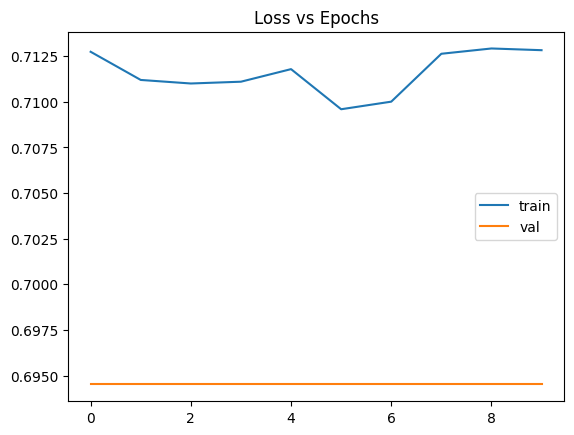

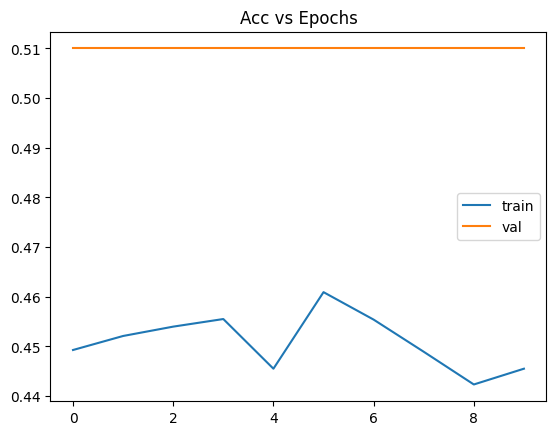

In [30]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_arr, label='train')
plt.plot(val_loss_arr, label='val')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

plt.plot(tr_acc_arr, label='train')
plt.plot(val_acc_arr, label='val')
plt.title('Acc vs Epochs')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = []
pred_labels = []

for inputs, attention_masks, labels in testA_loader:
    inputs, attention_masks, labels = inputs.to(
        device), attention_masks.to(device), labels.to(device)

    

    # Make predictions
    with torch.no_grad():
        outputs = model(
            inputs, attention_mask=attention_masks, labels=labels)[1]
        predictions = torch.argmax(outputs, axis=1)

    # Add true labels and predicted labels to the lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predictions.tolist())

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1:{:.4f}'.format(f1))


Accuracy: 0.5040
Precision: 0.5151
Recall: 0.5099
F1:0.4605


In [29]:
from sklearn.metrics import classification_report

target_names = ['not_hateful', 'hateful']
report = classification_report(
    true_labels, pred_labels, target_names=target_names)

print('Class-wise Metrics:')
print(report)


Class-wise Metrics:
              precision    recall  f1-score   support

 not_hateful       0.53      0.22      0.31       510
     hateful       0.50      0.80      0.61       490

    accuracy                           0.50      1000
   macro avg       0.52      0.51      0.46      1000
weighted avg       0.52      0.50      0.46      1000

